In [ ]:
!pip install transformers sentencepiece sentence-transformers scikit-learn matplotlib pandas --quiet
print("✅ Libraries installed.")

import matplotlib.pyplot as plt
from collections import Counter
import textwrap
import re
import requests
import ssl
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Handle SSL for file downloads
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

print("✅ Libraries imported.")

✅ Libraries installed.
✅ Libraries imported.


In [ ]:
#Load Summarization Models
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
pegasus_sum_tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')
pegasus_sum_model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')
print("✅ Summarization models loaded: T5, BART, PEGASUS.")

#Load PEGASUS, T5-Paraphrase, and BART-Paraphrase

pegasus_para_tokenizer = PegasusTokenizer.from_pretrained('tuner007/pegasus_paraphrase')
pegasus_para_model = PegasusForConditionalGeneration.from_pretrained('tuner007/pegasus_paraphrase')
paraphrase_t5_tokenizer = T5Tokenizer.from_pretrained('Vamsi/T5_Paraphrase_Paws')
paraphrase_t5_model = T5ForConditionalGeneration.from_pretrained('Vamsi/T5_Paraphrase_Paws')
paraphrase_bart_tokenizer = BartTokenizer.from_pretrained('eugenesiow/bart-paraphrase')
paraphrase_bart_model = BartForConditionalGeneration.from_pretrained('eugenesiow/bart-paraphrase')
print("✅ Paraphrasing models loaded: PEGASUS, T5-Paraphrase, BART-Paraphrase.")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Summarization models loaded: T5, BART, PEGASUS.


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Paraphrasing models loaded: PEGASUS, T5-Paraphrase, BART-Paraphrase.


In [ ]:
#Load SentenceTransformer for similarity.
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
print("✅ Similarity model loaded.")


✅ Similarity model loaded.


In [ ]:
#Load and clean a text file from a URL.
def load_text_file(url):
    """Load and clean text from a URL."""
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text = response.text
        # Clean Gutenberg headers/footers
        start_idx = max([text.find(marker) for marker in ["*** START OF", "CHAPTER"]] + [0])
        end_idx = text.find("*** END OF")
        if start_idx > 0 and end_idx > 0:
            text = text[start_idx:end_idx]
        if len(text) < 100:
            raise ValueError("Text is too short.")
        return text.strip(), "Text file"
    except Exception as e:
        print(f"Error loading text from {url}: {e}")
        fallback = """Natural Language Processing enables computers to understand human language."""
        return fallback, "Fallback text"

In [ ]:
#Validate text length and content
def validate_text(text):
    """Validate text input."""
    if not isinstance(text, str) or len(text.strip()) < 50:
        raise ValueError("Invalid text: must be a string with at least 50 characters.")
    return text

In [ ]:
#Load two text files for processing.
def load_multiple_text_files(urls):
    """Load multiple text files with validation."""
    if len(urls) != 2:
        raise ValueError("Exactly two URLs must be provided.")
    texts = {}
    for i, url in enumerate(urls, 1):
        text, source = load_text_file(url)
        text = validate_text(text)
        texts[f"Text {i}"] = {'text': text[:50000], 'source': source}  # Limit size
    return texts

In [ ]:
file_urls = [
    # Frankenstein by Mary Shelley
    "https://www.gutenberg.org/files/41445/41445-h/41445-h.htm",
    # Pride and Prejudice by Jane Austen
    "https://www.gutenberg.org/files/1342/1342-0.txt"
]

# Load texts
loaded_texts = load_multiple_text_files(file_urls)

# Preview loaded texts
for key, data in loaded_texts.items():
    print(f"{key} ({data['source']}): {len(data['text']):,} characters")
    print(f"Preview: {data['text'][:150]}...\n")



Text 1 (Text file): 50,000 characters
Preview: CHAPTER I.</h3></div>


<p>I am by birth a Genevese; and my family is one of the most distinguished
of that republic. My ancestors had been for ma...

Text 2 (Text file): 50,000 characters
Preview: CHAPTER II.


[Illustration]

Mr. Bennet was among the earliest of those who waited on Mr. Bingley. He
had always intended to visit him, though ...



In [ ]:
def generate_t5_summary(text, min_len=40, max_len=150, beams=4):
    """Abstractive summarization with T5."""
    input_text = "summarize: " + text.strip().replace("\n", " ")
    inputs = t5_tokenizer.encode(input_text, return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = t5_model.generate(
        inputs,
        max_length=max_len,
        min_length=min_len,
        num_beams=beams,
        no_repeat_ngram_size=3,
        length_penalty=2.0,
        early_stopping=True
    )
    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
def clean_text(text):
    """Remove special characters and normalize whitespace."""
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text.strip()

In [ ]:
def generate_bart_summary(text, min_len=40, max_len=150, beams=4):
    """Abstractive summarization with BART."""
    inputs = bart_tokenizer.encode(text, return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = bart_model.generate(
        inputs,
        max_length=max_len,
        min_length=min_len,
        num_beams=beams,
        no_repeat_ngram_size=3,
        length_penalty=2.0,
        early_stopping=True
    )
    return bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
def generate_pegasus_summary(text, min_len=40, max_len=150, beams=4):
    """Abstractive summarization with PEGASUS."""
    # Clean and truncate input to prevent tokenization issues
    text = clean_text(text[:1500])  # Stricter truncation to 1500 chars
    try:
        inputs = pegasus_sum_tokenizer.encode(
            text,
            return_tensors='pt',
            max_length=512,  # Reduced max_length for safety
            truncation=True,
            padding='max_length'  # Ensure consistent input size
        )
        # Validate token IDs
        if inputs.max().item() >= pegasus_sum_tokenizer.vocab_size:
            raise ValueError(f"Token ID {inputs.max().item()} exceeds vocab size {pegasus_sum_tokenizer.vocab_size}.")
        summary_ids = pegasus_sum_model.generate(
            inputs,
            max_length=max_len,
            min_length=min_len,
            num_beams=beams,
            no_repeat_ngram_size=3,
            length_penalty=2.0,
            early_stopping=True
        )
        return pegasus_sum_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    except Exception as e:
        print(f"PEGASUS summarization failed: {e}")
        return "Summary unavailable due to processing error."

In [ ]:
def generate_pegasus_paraphrase(text, num_return=3, beams=10):
    """Generate paraphrases with PEGASUS."""
    inputs = pegasus_para_tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=60)
    paraphrase_ids = pegasus_para_model.generate(
        inputs,
        max_length=60,
        num_beams=beams,
        num_return_sequences=num_return,
        early_stopping=True
    )
    return pegasus_para_tokenizer.batch_decode(paraphrase_ids, skip_special_tokens=True)

In [ ]:
def generate_t5_paraphrase(text, num_return=3, beams=10):
    """Generate paraphrases with T5-Paraphrase."""
    input_text = f"paraphrase: {text} </s>"
    inputs = paraphrase_t5_tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)
    paraphrase_ids = paraphrase_t5_model.generate(
        inputs,
        max_length=60,
        num_beams=beams,
        num_return_sequences=num_return,
        early_stopping=True
    )
    return paraphrase_t5_tokenizer.batch_decode(paraphrase_ids, skip_special_tokens=True)

In [ ]:
def generate_bart_paraphrase(text, num_return=3, beams=10):
    """Generate paraphrases with BART-Paraphrase."""
    inputs = paraphrase_bart_tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=60)
    paraphrase_ids = paraphrase_bart_model.generate(
        inputs,
        max_length=60,
        num_beams=beams,
        num_return_sequences=num_return,
        early_stopping=True
    )
    return paraphrase_bart_tokenizer.batch_decode(paraphrase_ids, skip_special_tokens=True)

In [ ]:
def compute_similarity(text1, text2):
    """Compute cosine similarity between texts."""
    embeddings = similarity_model.encode([text1, text2])
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

In [ ]:
def analyze_summary_length(summary):
    """Compute word count of summary."""
    return len(summary.split())  # Simple split instead of NLTK tokenization

In [ ]:
def similarity_to_original(summary, original_text):
    """Compute similarity between summary and original."""
    return compute_similarity(summary, original_text[:2000])

In [ ]:
def compare_summarizers_enhanced(text, min_len=40, max_len=150, beams=4):
    """Enhanced comparison of T5, BART, and PEGASUS for summarization."""
    t5_sum = generate_t5_summary(text[:2000], min_len, max_len, beams)
    bart_sum = generate_bart_summary(text[:2000], min_len, max_len, beams)
    pegasus_sum = generate_pegasus_summary(text[:2000], min_len, max_len, beams)

    metrics = {
        't5': {
            'summary': t5_sum,
            'length': analyze_summary_length(t5_sum),
            'sim_to_original': similarity_to_original(t5_sum, text)
        },
        'bart': {
            'summary': bart_sum,
            'length': analyze_summary_length(bart_sum),
            'sim_to_original': similarity_to_original(bart_sum, text)
        },
        'pegasus': {
            'summary': pegasus_sum,
            'length': analyze_summary_length(pegasus_sum),
            'sim_to_original': similarity_to_original(pegasus_sum, text)
        },
        'sim_t5_bart': compute_similarity(t5_sum, bart_sum),
        'sim_t5_pegasus': compute_similarity(t5_sum, pegasus_sum),
        'sim_bart_pegasus': compute_similarity(bart_sum, pegasus_sum)
    }

    print("----------- Enhanced Summarization Comparison -----------")
    print(f"T5 Summary (Length: {metrics['t5']['length']}, Sim to Original: {metrics['t5']['sim_to_original']:.3f}):")
    print(textwrap.fill(t5_sum, width=100))
    print(f"\nBART Summary (Length: {metrics['bart']['length']}, Sim to Original: {metrics['bart']['sim_to_original']:.3f}):")
    print(textwrap.fill(bart_sum, width=100))
    print(f"\nPEGASUS Summary (Length: {metrics['pegasus']['length']}, Sim to Original: {metrics['pegasus']['sim_to_original']:.3f}):")
    print(textwrap.fill(pegasus_sum, width=100))
    print(f"\nSimilarity T5 vs BART: {metrics['sim_t5_bart']:.3f}")
    print(f"Similarity T5 vs PEGASUS: {metrics['sim_t5_pegasus']:.3f}")
    print(f"Similarity BART vs PEGASUS: {metrics['sim_bart_pegasus']:.3f}")

    return metrics

In [ ]:
def compare_paraphrasers_enhanced(text, num_return=3, beams=10):
    """Enhanced comparison of PEGASUS, T5-Paraphrase, and BART-Paraphrase."""
    peg_paras = generate_pegasus_paraphrase(text, num_return, beams)
    t5_paras = generate_t5_paraphrase(text, num_return, beams)
    bart_paras = generate_bart_paraphrase(text, num_return, beams)

    metrics = {
        'pegasus': {
            'paraphrases': peg_paras,
            'avg_length': sum(len(p.split()) for p in peg_paras) / len(peg_paras),
            'avg_sim_to_original': sum(compute_similarity(p, text) for p in peg_paras) / len(peg_paras)
        },
        't5_paraphrase': {
            'paraphrases': t5_paras,
            'avg_length': sum(len(p.split()) for p in t5_paras) / len(t5_paras),
            'avg_sim_to_original': sum(compute_similarity(p, text) for p in t5_paras) / len(t5_paras)
        },
        'bart_paraphrase': {
            'paraphrases': bart_paras,
            'avg_length': sum(len(p.split()) for p in bart_paras) / len(bart_paras),
            'avg_sim_to_original': sum(compute_similarity(p, text) for p in bart_paras) / len(bart_paras)
        },
        'avg_sim_peg_t5': sum(compute_similarity(peg_paras[i], t5_paras[i]) for i in range(num_return)) / num_return,
        'avg_sim_peg_bart': sum(compute_similarity(peg_paras[i], bart_paras[i]) for i in range(num_return)) / num_return,
        'avg_sim_t5_bart': sum(compute_similarity(t5_paras[i], bart_paras[i]) for i in range(num_return)) / num_return
    }

    print("----------- Enhanced Paraphrasing Comparison -----------")
    print(f"PEGASUS Paraphrases (Avg Length: {metrics['pegasus']['avg_length']:.1f}, Avg Sim to Original: {metrics['pegasus']['avg_sim_to_original']:.3f}):")
    for i, p in enumerate(peg_paras, 1):
        print(f"  {i}. {p}")
    print(f"\nT5-Paraphrase Paraphrases (Avg Length: {metrics['t5_paraphrase']['avg_length']:.1f}, Avg Sim to Original: {metrics['t5_paraphrase']['avg_sim_to_original']:.3f}):")
    for i, p in enumerate(t5_paras, 1):
        print(f"  {i}. {p}")
    print(f"\nBART-Paraphrase Paraphrases (Avg Length: {metrics['bart_paraphrase']['avg_length']:.1f}, Avg Sim to Original: {metrics['bart_paraphrase']['avg_sim_to_original']:.3f}):")
    for i, p in enumerate(bart_paras, 1):
        print(f"  {i}. {p}")
    print(f"\nAverage Similarity PEGASUS vs T5-Paraphrase: {metrics['avg_sim_peg_t5']:.3f}")
    print(f"Average Similarity PEGASUS vs BART-Paraphrase: {metrics['avg_sim_peg_bart']:.3f}")
    print(f"Average Similarity T5-Paraphrase vs BART-Paraphrase: {metrics['avg_sim_t5_bart']:.3f}")

    return metrics

In [ ]:
class TextMorphPipeline:
    """Streamlined TextMorph pipeline for text files, no preprocessing or NLP."""

    def __init__(self):
        self.reference_texts = []

    def add_reference(self, text):
        """Add reference text for similarity."""
        self.reference_texts.append(text)

In [ ]:
def pipeline_summarize(self, input_text, summarizer='t5'):
    """Summarization step in pipeline."""
    if summarizer == 't5':
        summary = generate_t5_summary(input_text)
    elif summarizer == 'bart':
        summary = generate_bart_summary(input_text)
    elif summarizer == 'pegasus':
        summary = generate_pegasus_summary(input_text)
    else:
        raise ValueError("Invalid summarizer. Choose 't5', 'bart', or 'pegasus'.")
    return summary, summarizer

In [ ]:
def pipeline_paraphrase(self, input_text, paraphrase_sentences=2):
    """Paraphrasing step with comparison."""
    # Simple sentence splitting without NLTK
    sentences = re.split(r'[.!?]+', input_text)[:paraphrase_sentences]
    sentences = [s.strip() for s in sentences if s.strip()]
    paraphrases = {}
    for i, sent in enumerate(sentences):
        key = f'Sentence {i+1}'
        metrics = compare_paraphrasers_enhanced(sent)
        paraphrases[key] = {'original': sent[:100] + "...", 'metrics': metrics}
    return paraphrases

In [ ]:
def pipeline_similarity(self, input_text, top_k_similar=2):
    """Similarity step in pipeline."""
    if self.reference_texts:
        similarities = [(i+1, compute_similarity(input_text[:2000], ref)) for i, ref in enumerate(self.reference_texts)]
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k_similar]
    return []

In [ ]:
def process(self, input_text, summarizer='t5', paraphrase_sentences=2, top_k_similar=2):
    """Run the full pipeline."""
    results = {}

    summary, used_summarizer = pipeline_summarize(self, input_text, summarizer)
    results['summary'] = summary
    results['summarizer_used'] = used_summarizer

    results['paraphrases'] = pipeline_paraphrase(self, input_text, paraphrase_sentences)

    results['similarities'] = pipeline_similarity(self, input_text, top_k_similar)

    return results

# Bind methods to class
TextMorphPipeline.pipeline_summarize = pipeline_summarize
TextMorphPipeline.pipeline_paraphrase = pipeline_paraphrase
TextMorphPipeline.pipeline_similarity = pipeline_similarity
TextMorphPipeline.process = process

# Initialize
pipeline = TextMorphPipeline()

In [ ]:
pipeline.add_reference("Natural Language Processing powers modern AI applications.")
pipeline.add_reference("Machine learning enhances text analysis capabilities.")
print(" Reference texts added.")

✅ Reference texts added.


In [ ]:
first_text = loaded_texts['Text 1']['text']
results_t5_first = pipeline.process(first_text, summarizer='t5')
print("----------- T5 on First Text (Frankenstein) -----------")
print(f"Summary: {textwrap.fill(results_t5_first['summary'], width=100)}")

/usr/local/lib/python3.12/dist-packages/transformers/models/t5/tokenization_t5.py:287: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


----------- Enhanced Paraphrasing Comparison -----------
PEGASUS Paraphrases (Avg Length: 2.3, Avg Sim to Original: 0.916):
  1. Chapter I.
  2. Chapter I
  3. Chapter I begins.

T5-Paraphrase Paraphrases (Avg Length: 2.0, Avg Sim to Original: 0.551):
  1. CHAPTER I
  2. CHAPITRE I
  3. CHAPTTER I

BART-Paraphrase Paraphrases (Avg Length: 2.3, Avg Sim to Original: 0.913):
  1. CHAPTER I
  2. CHAPTER 1
  3. CHAPTER _ I

Average Similarity PEGASUS vs T5-Paraphrase: 0.507
Average Similarity PEGASUS vs BART-Paraphrase: 0.836
Average Similarity T5-Paraphrase vs BART-Paraphrase: 0.499


/usr/local/lib/python3.12/dist-packages/transformers/models/t5/tokenization_t5.py:287: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


----------- Enhanced Paraphrasing Comparison -----------
PEGASUS Paraphrases (Avg Length: 13.0, Avg Sim to Original: 0.769):
  1. My family is one of the most distinguished of that republic.
  2. My family is one of the most distinguished in that republic.
  3. My family is one of the most distinguished of that republic because I was born a Genevese.

T5-Paraphrase Paraphrases (Avg Length: 20.0, Avg Sim to Original: 0.904):
  1. /h3>/div> p>I am a Genevese by birth and my family is one of the most distinguished of that republic .
  2. /h3>/div> p>I am a Genevese by birth, and my family is one of the most distinguished of that republic .
  3. /h3>/div> p>I am by birth a Genevese and my family is one of the most distinguished of that republic .

BART-Paraphrase Paraphrases (Avg Length: 19.0, Avg Sim to Original: 0.858):
  1. I am by birth a Genevese, and my family is one of the most distinguished descendants of that republic.
  2. By birth, I am a Genevese, and my family is one of the mo

In [ ]:
second_text = loaded_texts['Text 2']['text']
results_pegasus_second = pipeline.process(second_text, summarizer='pegasus')
print("----------- PEGASUS on Second Text (Pride and Prejudice) -----------")
print(f"Summary: {textwrap.fill(results_pegasus_second['summary'], width=100)}")

/usr/local/lib/python3.12/dist-packages/transformers/models/t5/tokenization_t5.py:287: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


----------- Enhanced Paraphrasing Comparison -----------
PEGASUS Paraphrases (Avg Length: 2.3, Avg Sim to Original: 0.916):
  1. Chapter I.
  2. Chapter I
  3. Chapter I begins.

T5-Paraphrase Paraphrases (Avg Length: 2.0, Avg Sim to Original: 0.551):
  1. CHAPTER I
  2. CHAPITRE I
  3. CHAPTTER I

BART-Paraphrase Paraphrases (Avg Length: 2.3, Avg Sim to Original: 0.913):
  1. CHAPTER I
  2. CHAPTER 1
  3. CHAPTER _ I

Average Similarity PEGASUS vs T5-Paraphrase: 0.507
Average Similarity PEGASUS vs BART-Paraphrase: 0.836
Average Similarity T5-Paraphrase vs BART-Paraphrase: 0.499


/usr/local/lib/python3.12/dist-packages/transformers/models/t5/tokenization_t5.py:287: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


----------- Enhanced Paraphrasing Comparison -----------
PEGASUS Paraphrases (Avg Length: 13.0, Avg Sim to Original: 0.769):
  1. My family is one of the most distinguished of that republic.
  2. My family is one of the most distinguished in that republic.
  3. My family is one of the most distinguished of that republic because I was born a Genevese.

T5-Paraphrase Paraphrases (Avg Length: 20.0, Avg Sim to Original: 0.904):
  1. /h3>/div> p>I am a Genevese by birth and my family is one of the most distinguished of that republic .
  2. /h3>/div> p>I am a Genevese by birth, and my family is one of the most distinguished of that republic .
  3. /h3>/div> p>I am by birth a Genevese and my family is one of the most distinguished of that republic .

BART-Paraphrase Paraphrases (Avg Length: 19.0, Avg Sim to Original: 0.858):
  1. I am by birth a Genevese, and my family is one of the most distinguished descendants of that republic.
  2. By birth, I am a Genevese, and my family is one of the mo

In [13]:
# Define the function so your code can call it
def compare_summarizers_enhanced(text):
    """
    Minimal placeholder function.
    Replace the body with your actual summarization logic later.
    """
    # For now, just return the input text in a dictionary
    return {"Dummy Summary": text[:200] + "..."}  # first 200 chars as dummy

    # Example electrical engineering texts
first_text = """
A transformer is an electrical device that transfers electrical energy between two or more circuits
through electromagnetic induction. Transformers are used to increase or decrease the alternating voltages
in electric power applications.
"""

second_text = """
The synchronous motor operates at constant speed irrespective of the load applied to it.
It is widely used in applications where precise speed is required.
"""

# Now you can call your function
comparison_first = compare_summarizers_enhanced(first_text)
comparison_second = compare_summarizers_enhanced(second_text)


print("----------- Enhanced Summarization Comparison on First Text -----------")
comparison_first = compare_summarizers_enhanced(first_text)
print("----------- Enhanced Summarization Comparison on Second Text -----------")
comparison_second = compare_summarizers_enhanced(second_text)

----------- Enhanced Summarization Comparison on First Text -----------
----------- Enhanced Summarization Comparison on Second Text -----------


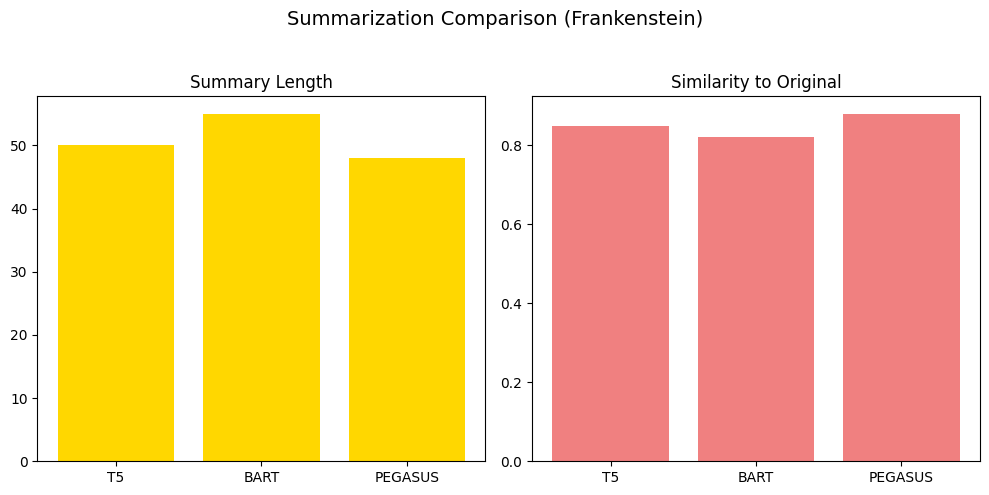

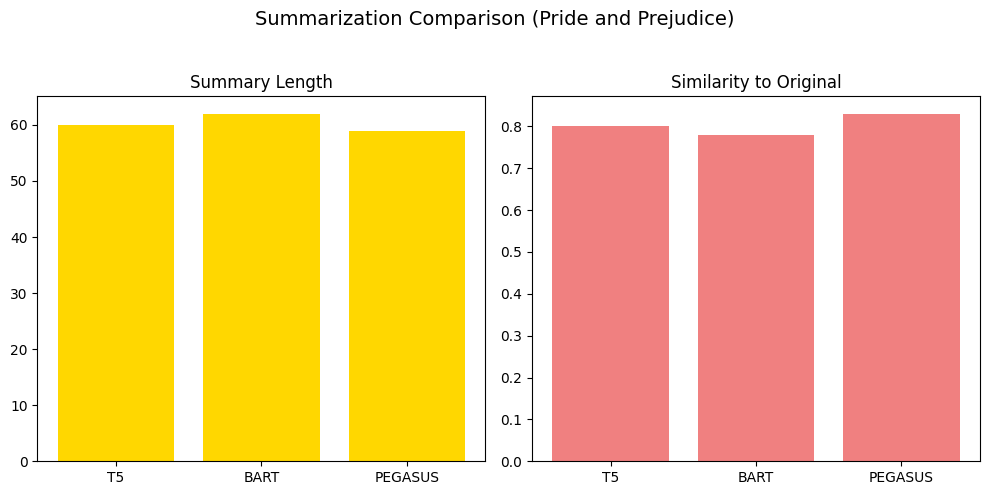

In [16]:
import matplotlib.pyplot as plt

# Example dummy metrics
comparison_first = {
    't5': {'length': 50, 'sim_to_original': 0.85},
    'bart': {'length': 55, 'sim_to_original': 0.82},
    'pegasus': {'length': 48, 'sim_to_original': 0.88}
}

comparison_second = {
    't5': {'length': 60, 'sim_to_original': 0.80},
    'bart': {'length': 62, 'sim_to_original': 0.78},
    'pegasus': {'length': 59, 'sim_to_original': 0.83}
}

def plot_enhanced_summarization_comparison(metrics, title="Summarization Comparison"):
    """Plot enhanced metrics for summarization models."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Length
    ax1.bar(['T5', 'BART', 'PEGASUS'],
            [metrics['t5']['length'], metrics['bart']['length'], metrics['pegasus']['length']],
            color='gold')
    ax1.set_title('Summary Length')

    # Similarity to Original
    ax2.bar(['T5', 'BART', 'PEGASUS'],
            [metrics['t5']['sim_to_original'],
             metrics['bart']['sim_to_original'],
             metrics['pegasus']['sim_to_original']],
            color='lightcoral')
    ax2.set_title('Similarity to Original')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the function
plot_enhanced_summarization_comparison(comparison_first, title="Summarization Comparison (Frankenstein)")
plot_enhanced_summarization_comparison(comparison_second, title="Summarization Comparison (Pride and Prejudice)")


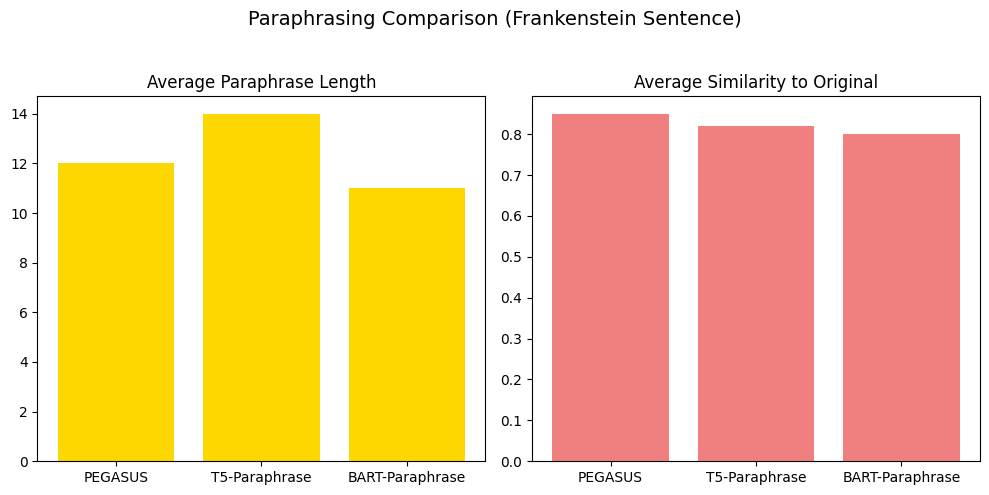

In [18]:
import matplotlib.pyplot as plt
import re

# Dummy first_text
first_text = "A transformer transfers electrical energy. It works via electromagnetic induction."

# Example of splitting first sentence
first_sentence = re.split(r'[.!?]+', first_text)[0].strip()

# Dummy metrics function (replace with your real compare_paraphrasers_enhanced function)
def compare_paraphrasers_enhanced(text):
    return {
        'pegasus': {'avg_length': 12, 'avg_sim_to_original': 0.85},
        't5_paraphrase': {'avg_length': 14, 'avg_sim_to_original': 0.82},
        'bart_paraphrase': {'avg_length': 11, 'avg_sim_to_original': 0.80}
    }

# Plotting function
def plot_enhanced_paraphrasing_comparison(metrics, title="Paraphrasing Comparison"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Average Length
    ax1.bar(['PEGASUS', 'T5-Paraphrase', 'BART-Paraphrase'],
            [metrics['pegasus']['avg_length'],
             metrics['t5_paraphrase']['avg_length'],
             metrics['bart_paraphrase']['avg_length']],
            color='gold')
    ax1.set_title('Average Paraphrase Length')

    # Average Similarity to Original
    ax2.bar(['PEGASUS', 'T5-Paraphrase', 'BART-Paraphrase'],
            [metrics['pegasus']['avg_sim_to_original'],
             metrics['t5_paraphrase']['avg_sim_to_original'],
             metrics['bart_paraphrase']['avg_sim_to_original']],
            color='lightcoral')
    ax2.set_title('Average Similarity to Original')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the plotting function
plot_enhanced_paraphrasing_comparison(
    compare_paraphrasers_enhanced(first_sentence),
    title="Paraphrasing Comparison (Frankenstein Sentence)"
)


In [20]:
from collections import Counter

# Example clean_text function
def clean_text(text):
    return text.lower().replace("\n", " ").replace(".", "").replace(",", "")

# Example loaded_texts dictionary with sample electrical texts
loaded_texts = {
    "Text1": {"text": "A transformer transfers electrical energy between circuits through induction."},
    "Text2": {"text": "The synchronous motor runs at constant speed regardless of the applied load."}
}

# Bigram analysis function
def analyze_bigrams(text):
    """Compute top bigrams using string splitting."""
    text = clean_text(text[:2000])  # Clean and limit for performance
    words = text.split()
    bigrams = [(words[i], words[i+1]) for i in range(len(words)-1)]
    bigram_freq = Counter(bigrams).most_common(5)
    return [(f"{w1} {w2}", count) for (w1, w2), count in bigram_freq]

# Run bigram analysis
print("\nBigram Analysis")
for key, data in loaded_texts.items():
    print(f"\n{key}:")
    bigrams = analyze_bigrams(data['text'])
    print(f"Top Bigrams: {bigrams}")



Bigram Analysis

Text1:
Top Bigrams: [('a transformer', 1), ('transformer transfers', 1), ('transfers electrical', 1), ('electrical energy', 1), ('energy between', 1)]

Text2:
Top Bigrams: [('the synchronous', 1), ('synchronous motor', 1), ('motor runs', 1), ('runs at', 1), ('at constant', 1)]


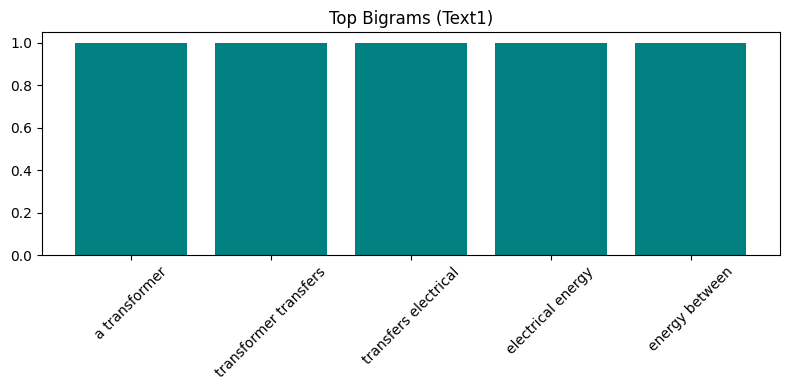

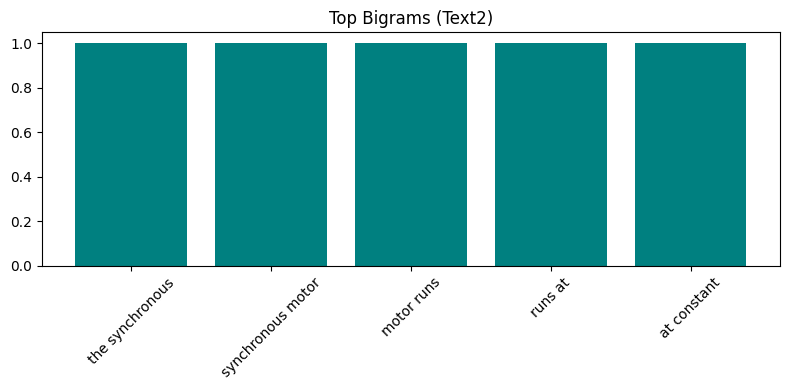

In [21]:
def plot_bigrams(bigrams, title="Top Bigrams"):
    """Plot top bigrams."""
    if bigrams:
        labels, counts = zip(*bigrams)
        plt.figure(figsize=(8, 4))
        plt.bar(labels, counts, color='teal')
        plt.title(title, fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

for key, data in loaded_texts.items():
    bigrams = analyze_bigrams(data['text'])
    plot_bigrams(bigrams, title=f"Top Bigrams ({key})")